<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Amirreza Zameni

**Student ID**: 400101504


# ****Support Vector Machines****

In this notebook, you will implement SVM for three datasets. You will become more familiar with the Soft-Margin SVM and the Kernel trick, which makes SVM extremely powerful.

Before we start our implementation, you must be comfortable with the theoretical details of the Soft-Margin SVM as an optimization problem and be able to derive the dual formulation for this problem. In the next sections, you will solve the dual optimization problem for all datasets using the CVXPY library, which has been developed for solving convex optimization problems. To get more familiar with CVXPY programming, you can use this [link](https://www.cvxpy.org).

This is the primal formulation for the Soft-Margin SVM for linearly separable data with slack variables $\xi_i \ge 0$:

\begin{equation*}
\begin{aligned}
& {\text{min.}}
& & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \xi_i \\
& \text{s.t.}
& & y_i(w^T x_i + b) \geq 1 - \xi_i, \; i = 1, \ldots, N \\
& & & \xi_i \geq 0, \; i = 1, \ldots, N
\end{aligned}
\end{equation*}

Where $w$ represents the weight vector, $b$ is the bias term, and $C$ is the regularization parameter controlling the trade-off between a wide margin and misclassification.

**Theoretical Questions:**

1) Derive the dual optimization problem for the Soft-Margin SVM.

$$ \min_{w, b} \frac{1}{2} \|w\|^2 $$

$$ \min_{w, b, \xi} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i $$

$$ L(w, b, \xi, \alpha) = \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i - \sum_{i=1}^n \alpha_i [y_i(w \cdot x_i + b) - 1 + \xi_i] $$

$$ \max_{\alpha} \min_{w, b, \xi} L(w, b, \xi, \alpha) $$

$$ \max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j (x_i \cdot x_j) $$

$$ \max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j K(x_i, x_j) $$

subject to 
$$ \sum_{i=1}^n \alpha_i y_i = 0$$
$$ 0 <= \alpha_i <= C$$

if we use kernel we have:

<img src="slide1 (1).png" alt="image info" width=600 height=400 />
<img src="slide1 (2).png" alt="image info" width=600 height=400/>
<img src="slide1 (3).png" alt="image info" width=600 height=400/>

2) How do we calculate the weights and bias ($w$ and $b$) using the dual problem optimum points?

Weight Vector and Bias:
The optimal weight vector (w) can be expressed as: $$[ w = \sum_{i=1}^n \alpha_i y_i x_i ]$$
The bias term (b) can be computed using any support vector $$ (data point with non-zero (\alpha_i)): [ b =(1/N) \sum_{i} y_j - w \cdot x_j \quad \text{for some support vector and N is number of them} x_j ]$$

3) How do we classify new data points using the optimal weights and bias?
<br>it is discussed above in the images


<font color='green'>Write down your answers as markdown here.</font>

Sometimes, the data is not linearly separable. Therefore, the previous formulation of the Soft-Margin SVM does not give a good accuracy for the classification problem. The Kernel trick is a technique used in such situations. Consider $x$ as your input features with dimension $p$. One can use function $\phi: R^p → R^d$ to map the input features to another space with dimension $d$. Finding good $\phi$ such that data points become near linearly separable makes the previous formulation of the problem and its dual useful by replacing $\phi(x_i)$ for $x_i$ in the problem definition. The function $\phi(x)$ can even be a mapping to an infinite-dimensional space.

If you have found the correct dual form of the Soft-Margin SVM in the previous formulation, you can see that the terms $x_i^T x_j$ will appear in the problem formulation and the prediction rule. These terms will be replaced with $\phi(x_i)^T \phi(x_j)$ when we use $\phi$ as our feature mapping function. Given a feature mapping $\phi$ we define its corresponding **Kernel** to be:

\begin{equation*}
\begin{aligned}
& K(x, z) = \phi(x)^T \phi(z)
\end{aligned}
\end{equation*}

Hence, in the dual optimization problem and the prediction rule of the Soft-Margin SVM, we can replace all terms in the form $x^T z$ with $K(x, z)$. This technique is called the Kernel trick.

Now, given $\phi$, we could easily compute $K(x,z)$ by finding $\phi(x)$ and $\phi(z)$ and taking their inner product. But what’s more interesting is that often, $K(x,z)$ may be very inexpensive to calculate, even though $\phi(x)$ itself may be very expensive to calculate (perhaps because it is an extremely high-dimensional vector). Check Stanford's CS229 [notes](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf) on SVM and the Kernel trick for more details and examples.

## Libraries

Here are some useful libraries for the implementation. You can add or remove any libraries as you wish. Note that you cannot use sklearn or similar libraries for implementation.

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import cvxpy as cp
from sklearn.metrics import classification_report

## **Dataset Exploration**

In this notebook, you'll be working with three datasets, specifically named "DF1.csv", "DF2.csv", and "DF3.csv". Each dataset entry is composed of a 2-dimensional feature vector and a label, which is either "1" or "-1". The primary objective of this notebook is to leverage SVM to develop a robust classifier for each dataset.

You are given three kernels as follows:



1.   Linear Kernel: $K(x, z) = x^T z$
2.   Polynomial Kernel of degree 2: $K(x, z) = (1 + ∑_{i = 1}^{p} x_i z_i)^2$, where $p$ is the dimension of the feature space.
3.   RBF Kernel: $K(x, z) = e^{-\frac{||x-z||_2^2}{2σ^2}}$

Before implementing, you must choose the correct kernel for each dataset. Note that each kernel must be used exactly for one dataset. Therefore, you cannot use one of the kernels twice. As a part of our grading scheme, what matters with respect to accuracy is the sum of the accuracies you reach for all three datasets, and the accuracy of each model does not have any separate score. Thus, it would help if you chose the most appropriate kernel for each dataset so that all datasets reach a reasonably good accuracy.





Load all datasets and show the first 5 rows of each.

In [3]:
## YOUR CODE HERE
data=[]
data =data+ [pd.read_csv('DF1.csv')]
data =data+ [pd.read_csv('DF2.csv')]
data =data+ [pd.read_csv('DF3.csv')]

for i in range(len(data)):
    print(f'First 5 rows of data set {i+1} :')
    print(data[i].head())

First 5 rows of data set 1 :
         x1        x2  y
0  6.462652  5.121478 -1
1 -6.586541 -7.721287  1
2  9.239683 -8.595738 -1
3  4.250052  2.143755  1
4  8.219779 -3.609733 -1
First 5 rows of data set 2 :
         x1         x2  y
0  2.937145  77.102291  1
1 -0.029344  44.802353  1
2  5.868818  44.595757 -1
3  8.609281  49.223945 -1
4  7.763276 -14.340750 -1
First 5 rows of data set 3 :
         x1        x2  y
0 -0.517768 -0.466158 -1
1  0.940985  0.235175  1
2 -0.470720  0.917120  1
3  0.712716 -0.097401 -1
4 -0.608773 -0.107034 -1


Use the following function to visualize the datapoints for all datasets.

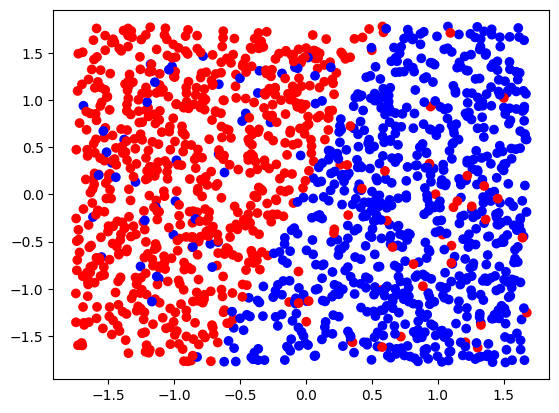

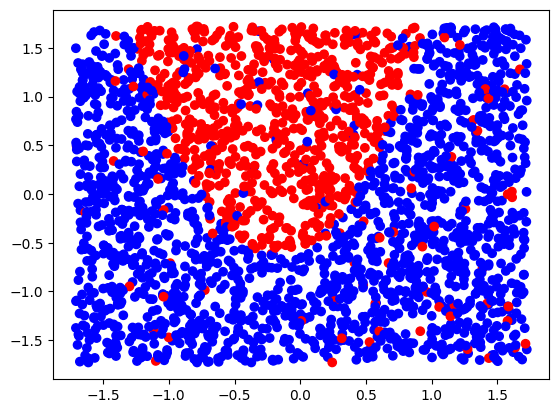

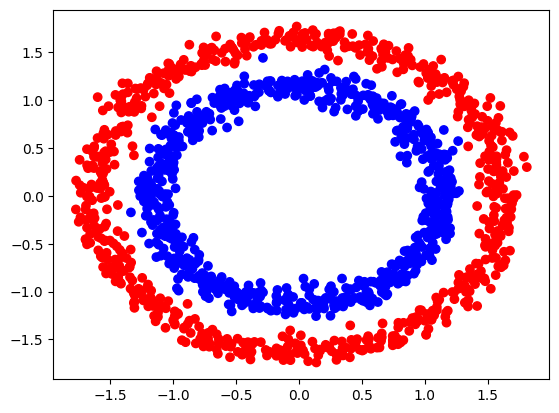

In [8]:
def numpy_set(data):
  X=data.iloc[:,:-1].values
  Y=data.iloc[:,-1].values
  scaler = StandardScaler()
  return scaler.fit_transform(X),Y
def visualize_data(X, y):
  col = []
  for i in range(len(y)):
    if y[i] == 1:
      col.append('red')
    else:
      col.append('blue')
  plt.figure()
  plt.scatter(X[ : , 0], X[ : , 1], color = col)
  plt.show()

## YOUR CODE HERE
Xs=[]
Ys=[]
for i in data:
  tempx,tempy=numpy_set(i)
  Xs.append(tempx)
  Ys.append(tempy)
  visualize_data(tempx,tempy)


**Theoretical Question:**

Which kernel will you use for each dataset? Justify your answer.<br>
linear kernel for DF1 because as we can see classes are linearly seperatable.<br>
Polynomial Kernel of degree 2 for DF3 because as we can see classes can be seperated according to their distance from the
origin so Polynomial Kernel of degree 2 can make them linearly seperatable.<br>
RBF Kernel for DF3 because as we can see data has a very close  distribution to guassian so RBF can be a good kernel for it.<br>
Note: your implementation must follow your choice here. Otherwise, you do not recieve any points for your implemetation.

<font color='green'>Write down your answers as markdown here.</font>

## Dataset one (DF1.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [11]:
## YOUR CODE HERE
X_tests=[]
X_trains=[]
y_tests=[]
y_trains=[]
for i in range(len(data)):
    train, test, y_train, y_test = train_test_split(Xs[i], Ys[i], test_size=0.2, random_state=42)
    X_tests.append(test)
    X_trains.append(train)
    y_tests.append(y_test)
    y_trains.append(y_train)
    



In [311]:

class MySVM:
    def __init__(self, kernel, C=1.0):
        self.kernel = kernel
        self.C = C
        self.b=None
    def fit(self, X, y):
        y=y.astype('float64')
        n=X.shape[0]
        S_mat=self.set_S(X,y)
        self.alphas=self.dual_solver(S_mat,y)
        self.b = self.calculate_b(X,y)
        self.X_train=X
        self.y_train=y
    def calculate_b(self,X,y):
        sum1=0
        w0=0
        for i in range(len(self.alphas)):
                if(self.alphas[i]!=0):
                   sum1+=1
                sum2=0
                for j in range(len(self.alphas)):
                        sum2+=self.alphas[j]*y[j]*self.kernel(X[i,:],X[j,:])
                w0=w0+y[i]-sum2
        print(w0/sum1)        
        return w0/sum1
    def dual_solver(self,S_mat,y):
        n=S_mat.shape[0]
        alpha = cp.Variable(n)
        Y = np.diag(y)
        P = cp.psd_wrap(Y @ S_mat @ Y)
        dual_objective = cp.Maximize(cp.sum(alpha) - (1 / (2)) * cp.quad_form(alpha,P))
        dual_constraints = [0 <= alpha, alpha <= self.C, cp.sum(cp.multiply(y, alpha)) == 0]
        dual_problem = cp.Problem(dual_objective, dual_constraints)
        dual_problem.solve()
        return alpha.value

        

    def predict(self, X):
        predictions=np.zeros(X.shape[0])
        for j in range(len(predictions)):
            sum1=0
            for i in range(len(self.alphas)):
                    sum1=sum1+self.alphas[i]*self.y_train[i]*self.kernel(self.X_train[i],X[j])
            predictions[j] = np.sign(sum1+self.b)
        return predictions
    def set_S(self, X,y):
        n=X.shape[0]
        t_S=np.zeros(shape=(n,n))
        for i in range(n):
            for j in range(n):
                t_S[i,j]=self.kernel(X[i,:],X[j,:])
        return t_S



Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

-0.02776073342387617


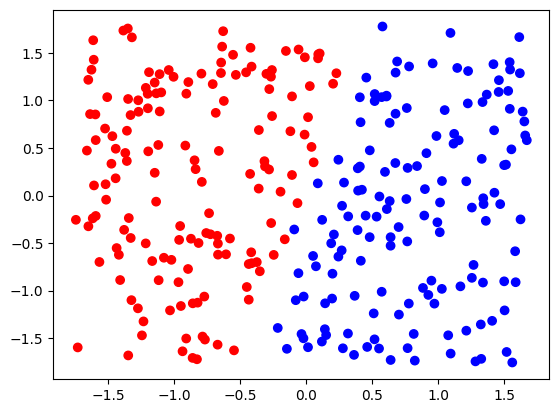

In [318]:
## YOUR CODE HERE
def linear_kernel(vector_a, vector_b):
    return np.dot(vector_a, vector_b)
svm_model=MySVM(linear_kernel,1)
svm_model.fit(X_trains[0],y_trains[0])
y_pred=svm_model.predict(X_tests[0])
visualize_data(X_tests[0],y_pred)


Predict the class of each entry in the test set using your learned model.

In [ ]:
## YOUR CODE HERE


Use classification_report function (from sklearn) to get the accuracy of your model.

In [319]:
print(classification_report(y_tests[0],y_pred))


              precision    recall  f1-score   support

          -1       0.92      0.91      0.92       148
           1       0.91      0.93      0.92       148

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296



## Dataset two (DF2.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [ ]:
## YOUR CODE HERE



Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [ ]:
## YOUR CODE HERE


Predict the class of each entry in the test set using your learned model.

-0.6017321245286059


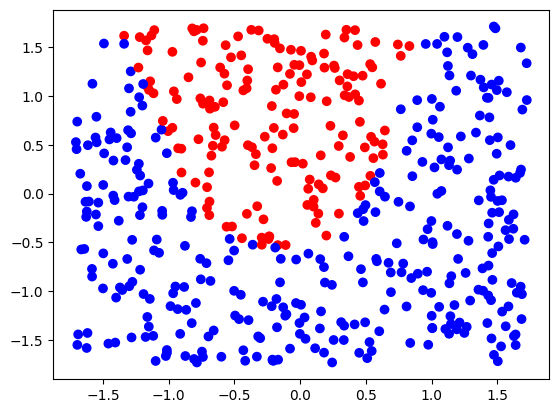

In [316]:
## YOUR CODE HERE
def rbf_kernel(x, z):
    sigma=1
    return np.exp(-np.linalg.norm(x - z) ** 2 / (2 * sigma ** 2))


svm_model=MySVM(rbf_kernel,1)
svm_model.fit(X_trains[1],y_trains[1])
y_pred=svm_model.predict(X_tests[1])
visualize_data(X_tests[1],y_pred)


Use classification_report function (from sklearn) to get the accuracy of your model.

In [317]:
## YOUR CODE HERE
print(classification_report(y_tests[1],y_pred))

              precision    recall  f1-score   support

          -1       0.95      0.93      0.94       336
           1       0.87      0.89      0.88       160

    accuracy                           0.92       496
   macro avg       0.91      0.91      0.91       496
weighted avg       0.92      0.92      0.92       496



## Dataset three (DF3.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

-7.212529027522808


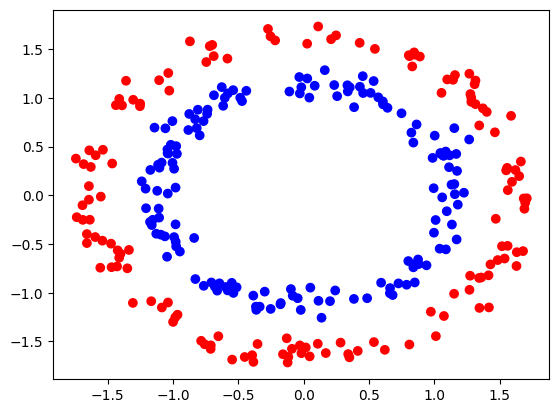

In [314]:
## YOUR CODE HERE
def polynomial_kernel(x, z):
    return (1 + x@z.T) ** 2

svm_model=MySVM(polynomial_kernel,1)

svm_model.fit(X_trains[2],y_trains[2])
y_pred=svm_model.predict(X_tests[2])
visualize_data(X_tests[2],y_pred)


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [ ]:
## YOUR CODE HERE
# don in class

Predict the class of each entry in the test set using your learned model.

In [ ]:
## YOUR CODE HERE
# don in class

Use classification_report function (from sklearn) to get the accuracy of your model.

In [315]:
## YOUR CODE HERE
print(classification_report(y_tests[2],y_pred))


              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       152
           1       1.00      1.00      1.00       140

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292



sum of accuracies: 100+92+92=384